In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
import tensorflow_probability as tfp
import h5py
import random
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
import photoz_utils

In [3]:
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions

In [4]:
from tensorflow_probability.python.distributions import kl_divergence

In [5]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
n = 10000
t = 2000
v = 2000

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation_small.hdf5', 'r')
x_train = np.asarray(np.transpose(hf_train['image'][0:n],(0,2,3,1)))
x_test = np.asarray(np.transpose(hf_test['image'][0:t],(0,2,3,1)))
x_validation = np.asarray(np.transpose(hf_validation['image'][0:v],(0,2,3,1)))
max_value = np.max(np.array([np.max(x_train), np.max(x_test), np.max(x_validation)]))
x_train = np.true_divide(x_train,max_value)
x_test = np.true_divide(x_test,max_value)
x_validation = np.true_divide(x_validation,max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:n])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:t])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:v])[..., None]
oid_train = np.asarray(hf_train['object_id'][0:n])
oid_test = np.asarray(hf_test['object_id'][0:t])
oid_validation = np.asarray(hf_validation['object_id'][0:v])
hf_train.close()
hf_test.close()
hf_validation.close()

In [8]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= 0 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=0.1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [9]:
import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [10]:
model_variational = Sequential([
    InputLayer(input_shape = (127, 127, 5)),
    tfpl.Convolution2DFlipout(32, kernel_size=(2, 2), activation = 'tanh', kernel_divergence_fn = kl_divergence_function),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'tanh'),
    MaxPooling2D(2, 2),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Conv2D(32, kernel_size = (2, 2), activation = 'relu'),
    Flatten(),
    Dropout(0.2),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    tfpl.DenseVariational(64, 
                                      make_posterior_fn = posterior_mean_field,
                                      make_prior_fn = prior_trainable,
                                      kl_weight = 1 / n),
    Dense(tfpl.IndependentNormal.params_size(1)),
    tfpl.IndependentNormal(1)
])

model_variational.build((10000, 127, 127, 5))

model_variational.summary()

/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (10000, 127, 127, 5)      0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (10000, 126, 126, 32)     1312      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (10000, 63, 63, 32)       0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (10000, 62, 62, 32)       4128      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (10000, 31, 31, 32)       0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (10000, 30, 30, 32)       4128      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (10000, 29, 29, 32)       4

In [11]:
def loss_function(targets, estimated_distribution):
    return - estimated_distribution.log_prob(targets) / (1 + targets)

model_variational.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = loss_function, metrics = [keras.metrics.RootMeanSquaredError()])

In [12]:
import tensorboard

model_name = 'HSC_v6_BCNN_v1'

checkpoint_filepath = os.path.join('/models/', model_name) + '/' + model_name

log_dir = os.path.join('/logs/', model_name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, verbose = 1, save_freq = 150*250)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [ ]:
model_variational.fit(x = x_train, y = y_train, epochs = 900, shuffle = True, verbose = 1, validation_data = (x_validation, y_validation), callbacks = [tensorboard_callback, cp_callback])

In [ ]:
model_variational.save(checkpoint_filepath, save_traces = False)

In [13]:
model_variational.load_weights(checkpoint_filepath)

In [14]:
y_test_prediction = []

for i in range(t):
    y_test_prediction.append(model_variational(np.array([x_validation[i]])).mean()[0][0])

y_test_prediction = np.asarray(y_test_prediction).astype('float32')

In [15]:
y_test_spectro = np.asarray(y_validation)[:,0]

In [16]:
y_test_std = []

for i in range(t):
    y_test_std.append(model_variational(np.array([x_validation[i]])).stddev()[0][0])

In [17]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_spectro, y_test_prediction])).astype('float32')
z = gaussian_kde(xy)(xy)

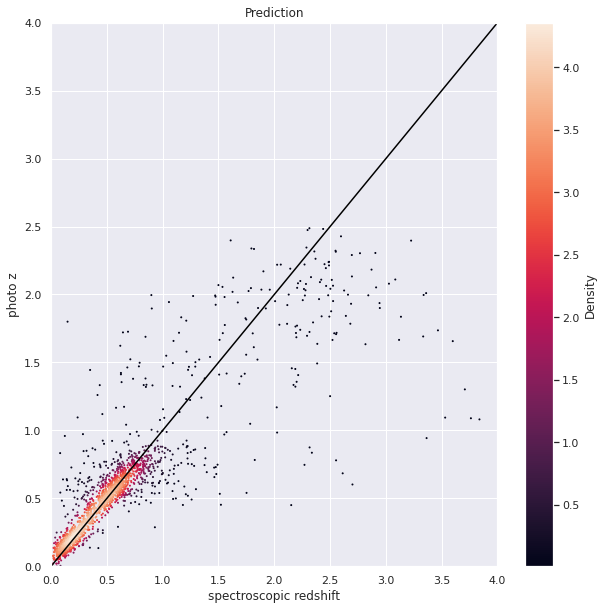

In [18]:
import seaborn as sns
z_max = 4
sns.set(rc={'figure.figsize':(10, 10), 'lines.markersize':20})
plt.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_spectro, y_test_prediction, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [19]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0,t):
    if np.abs(y_test_spectro[i]-y_test_prediction[i])<=y_test_std[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)

Coverage: 0.539


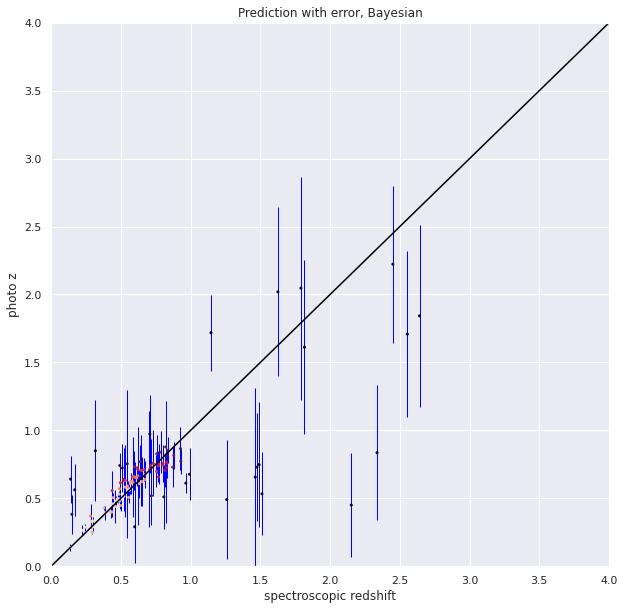

In [20]:
fig, ax = plt.subplots()
display_size = 100
scatter_plot = ax.scatter(y_test_spectro[:display_size], y_test_prediction[:display_size], c = z[:display_size], s = 4, edgecolor = None, zorder = 2)
error_plot = ax.errorbar(y_test_spectro[:display_size], y_test_prediction[:display_size], yerr = y_test_std[:display_size], fmt="o", markersize=0, color = 'blue', elinewidth = 1, zorder = 1)
plt.title('Prediction with error, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
print("Coverage: "+str(overlap_variational/t))

In [21]:
combined_array_variational = np.transpose(np.vstack((y_test_spectro, y_test_prediction, y_test_std, overlap_array_variational))) 

In [22]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x: x[0])

In [23]:
bins_variational = int(z_max*5)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational, bins_variational)
coverage_variational = []
for i in range(0, bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational/len(splitted_sorted_combined_array_variational[i])/0.6827)
x_array = np.arange(0, z_max, z_max/bins_variational)

Coverage: 0.539


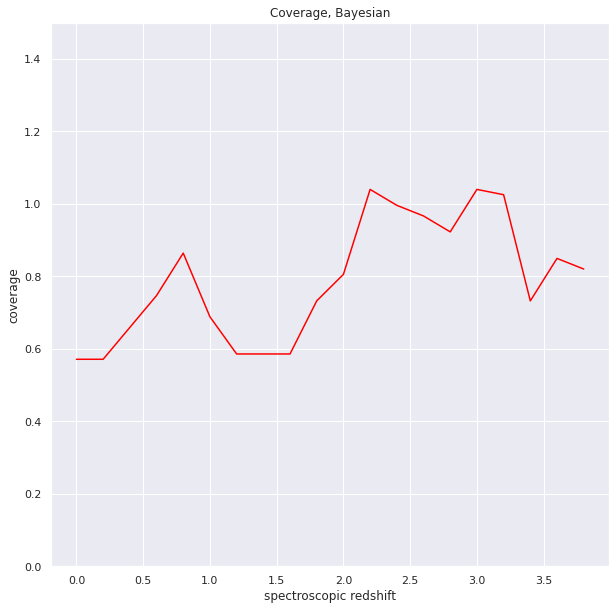

In [24]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.title('Coverage, Bayesian')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0, 1.5])
print("Coverage: "+str(overlap_variational/t))

In [25]:
mean_array = []
for i in range(0, bins_variational):
    total = 0
    for j in range(0, len(splitted_sorted_combined_array_variational[i])):
        bias = (splitted_sorted_combined_array_variational[i][j][1]-splitted_sorted_combined_array_variational[i][j][0])
        total += bias
    mean_array.append(total/len(splitted_sorted_combined_array_variational[i]))
x_array = np.arange(0, z_max, z_max/bins_variational)

In [26]:
error_array = []
for i in range(0,bins_variational):
    error_total = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        error_total += splitted_sorted_combined_array_variational[i][j][2]
    error_array.append(error_total/len(splitted_sorted_combined_array_variational[i]))

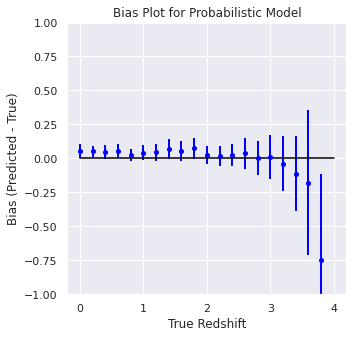

In [27]:
sns.set(rc={'figure.figsize':(5, 5), 'lines.markersize':40})
plt.rcParams.update({'font.size': 40})
plt.errorbar(x_array, mean_array, yerr = error_array, fmt = "o", color = 'blue', markersize = 4, elinewidth = 2)
plt.title('Bias Plot for Probabilistic Model')
plt.xlabel('True Redshift')
plt.ylabel('Bias (Predicted - True)')
plt.plot([0, z_max], [0, 0],color = 'black')
plt.ylim([-1, 1])
plt.show()

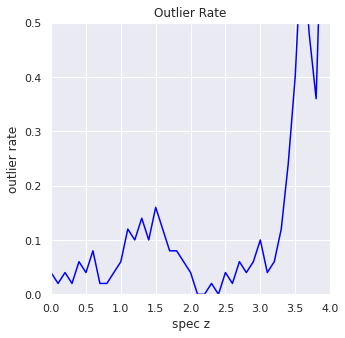

Outlier Rate: 0.123


In [28]:
combined_outlier_array = np.transpose(np.vstack((y_test_spectro,np.subtract(y_test_prediction, y_test_spectro))))
sorted_combined_outlier_array = sorted(combined_outlier_array, key=lambda x: x[0])
bins_outlier = int(z_max*10)
splitted_sorted_combined_outlier_array = np.array_split(sorted_combined_outlier_array,bins_outlier)
outlier_array = []
outlier_count_total = 0
for i in range(0,bins_outlier):
    outlier_count = 0
    for j in range(0,len(splitted_sorted_combined_outlier_array[i])):
        if np.abs(splitted_sorted_combined_outlier_array[i][j][1]/(splitted_sorted_combined_outlier_array[i][j][0] + 1)) >= .15:
            outlier_count += 1
            outlier_count_total += 1
    outlier_array.append(outlier_count/len(y_test_spectro)*bins_outlier)
x_array_outlier = np.arange(0,z_max,z_max/bins_outlier)
plt.plot(x_array_outlier, outlier_array, c = 'blue')
plt.title('Outlier Rate')
plt.xlabel('spec z')
plt.ylabel('outlier rate')
plt.xlim([0,z_max])
plt.ylim([0,1/2])
plt.show()

print("Outlier Rate: "+str(outlier_count_total/len(y_test_spectro)))

In [29]:
photoz_utils.save_with_oid_std(model_name, oid_test, y_test_spectro, y_test_prediction, y_test_std)

FileNotFoundError: [Errno 2] No such file or directory: '/predictions/2022_08/HSC_v6_BCNN_v1/2022_08_03_00:48:54.csv'

In [ ]:
# END